### 작성일 : 19/7/21
### 목적 : 데이터 컬럼 별 분포/특징점 파악 

### 0 . load libraies & data import 

In [1]:
library(data.table)
library(ggplot2)
library(dplyr)
options(repr.plot.width = 5, repr.plot.height = 3)
options(scipen = 100)
library(ggpubr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: magrittr


In [2]:
tr <- fread("/Users/jeong/downloads/IEEE/input/train_transaction.csv")
te <- fread("/Users/jeong/downloads/IEEE/input/test_transaction.csv")

#tr_id <- fread("/Users/jeong/downloads/IEEE/input/train_identity.csv")
#te_id <- fread("/Users/jeong/downloads/IEEE/input/test_identity.csv")

In [3]:
dim(tr)
dim(te)

dim(tr_id)
dim(te_id)

[1] 590540    394

[1] 506691    393

[1] 144233     41

[1] 141907     41

In [4]:
te$isFraud = -1
tt <- rbind(tr, te)

In [5]:
head(tr)

TransactionID isFraud TransactionDT TransactionAmt ProductCD card1 card2
1 2987000       0       86400         68.5           W         13926  NA  
2 2987001       0       86401         29.0           W          2755 404  
3 2987002       0       86469         59.0           W          4663 490  
4 2987003       0       86499         50.0           W         18132 567  
5 2987004       0       86506         50.0           H          4497 514  
6 2987005       0       86510         49.0           W          5937 555  
  card3 card4      card5 ⋯ V330 V331 V332 V333 V334 V335 V336 V337 V338 V339
1 150   discover   142   ⋯ NA   NA   NA   NA   NA   NA   NA   NA   NA   NA  
2 150   mastercard 102   ⋯ NA   NA   NA   NA   NA   NA   NA   NA   NA   NA  
3 150   visa       166   ⋯ NA   NA   NA   NA   NA   NA   NA   NA   NA   NA  
4 150   mastercard 117   ⋯ NA   NA   NA   NA   NA   NA   NA   NA   NA   NA  
5 150   mastercard 102   ⋯  0    0    0    0    0    0    0    0    0    0  
6 150   visa       226   ⋯ NA   NA   NA   NA   NA   NA   NA   NA   NA   NA

In [6]:
head(tr_id)

TransactionID id_01 id_02  id_03 id_04 id_05 id_06 id_07 id_08 id_09 ⋯
1 2987004        0     70787 NA    NA    NA    NA    NA    NA    NA    ⋯
2 2987008       -5     98945 NA    NA     0    -5    NA    NA    NA    ⋯
3 2987010       -5    191631  0     0     0     0    NA    NA     0    ⋯
4 2987011       -5    221832 NA    NA     0    -6    NA    NA    NA    ⋯
5 2987016        0      7460  0     0     1     0    NA    NA     0    ⋯
6 2987017       -5     61141  3     0     3     0    NA    NA     3    ⋯
  id_31               id_32 id_33     id_34          id_35 id_36 id_37 id_38
1 samsung browser 6.2 32    2220x1080 match_status:2 T     F     T     T    
2 mobile safari 11.0  32    1334x750  match_status:1 T     F     F     T    
3 chrome 62.0         NA                             F     F     T     T    
4 chrome 62.0         NA                             F     F     T     T    
5 chrome 62.0         24    1280x800  match_status:2 T     F     T     T    
6 chrome 62.0         24    1366x768  match_status:2 T     F     T     T    
  DeviceType DeviceInfo                   
1 mobile     SAMSUNG SM-G892A Build/NRD90M
2 mobile     iOS Device                   
3 desktop    Windows                      
4 desktop                                 
5 desktop    MacOS                        
6 desktop    Windows

### 1. Target 분포 확인

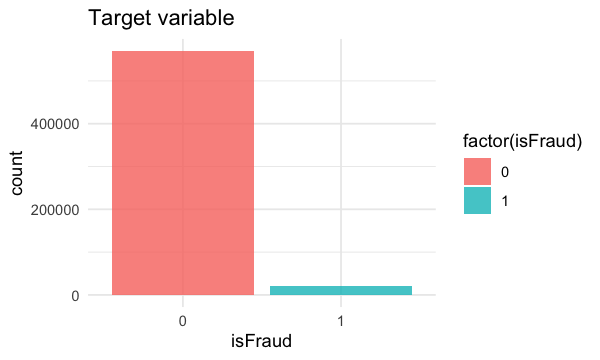

In [7]:
ggplot(tr, aes(factor(isFraud), fill = factor(isFraud))) + geom_bar(alpha = 0.8)  + theme_minimal() +
    ggtitle("Target variable") + labs(x = "isFraud")

매우 imbalance한 Target 분포

### 2. TransactionDT

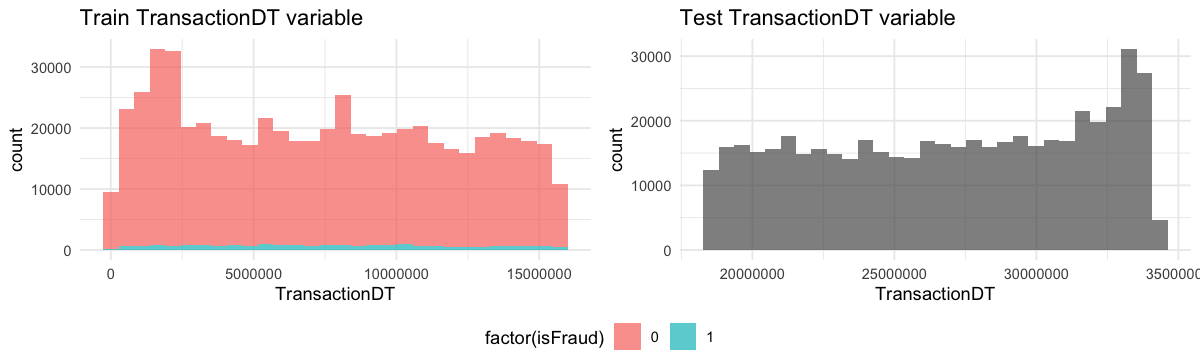

In [8]:
a1  <- ggplot(tr, aes(TransactionDT, fill = factor(isFraud))) + geom_histogram(alpha = 0.7, bins = 30)  + theme_minimal() +
    ggtitle("Train TransactionDT variable") + labs(x = "TransactionDT") + theme(legend.position = "bottom")

b1 <- ggplot(te, aes(TransactionDT)) + geom_histogram(alpha = 0.7, bins = 30)  + theme_minimal() +
    ggtitle("Test TransactionDT variable") + labs(x = "TransactionDT")

theme_set(theme_pubr())
options(repr.plot.width = 10, repr.plot.height = 3)
figure <- ggarrange(a1, b1,
                    common.legend = TRUE, legend = "bottom",
                    nrow = 1, ncol = 2)
figure

TransactionDT 컬럼을 본 결과 두가지 특이점을 확인했다.

2.1) Train/Test 데이터는 시간 순으로 완벽하게 분리되어있다.
즉, TransactionDT 변수는 Test dataset 모델 예측에 도움이 되지 못할것이며, validation 데이터셋을 정하는대에도 이 점을 늘 염두해 두어야 할것이다.

2.2) 두 데이터 모두 치솟는 구간(peak)이 존재하며, 데이터 상에서 peak이 나오는 패턴이 서로 다른데,

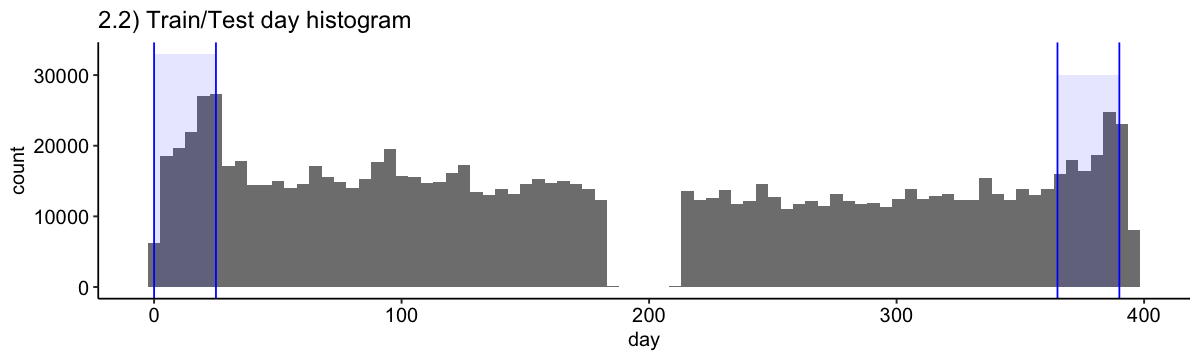

In [9]:
tt$day  <- tt$TransactionDT / 60 / 60 / 24
ggplot(tt, aes(day)) + geom_histogram(bins = 80, alpha = 0.8) +
    ggtitle("2.2) Train/Test day histogram") +
    geom_vline(xintercept = 0, colour="blue") +
    geom_vline(xintercept = 25, colour="blue") +
    geom_vline(xintercept = 0 + 365, colour="blue") +
    geom_vline(xintercept = 25 + 365, colour="blue") +
    annotate("rect", xmin=0, xmax=25, ymin= 0, ymax= 33000, alpha=0.1, fill="blue") +
    annotate("rect", xmin=0+365, xmax=25 +365, ymin= 0, ymax= 30000, alpha=0.1, fill="blue")

TransactionDT 값을 초 단위로 가정하여 day값으로 만든 결과, yearly 패턴이 보이는 것을 확인할 수 있었다.  
2.2.1) peak이 발생하는 구간과 이외의 구간의 비교 필요 2.2.2) yearly 패턴 외에 weekly, 또는 요일별, 시간대별 fraud rate의 특성이 보이는 경우는 없을까? 그리고 hour of day /hour of week 등등 여러가지
변수들을 조합하여 비교도 추가 진행

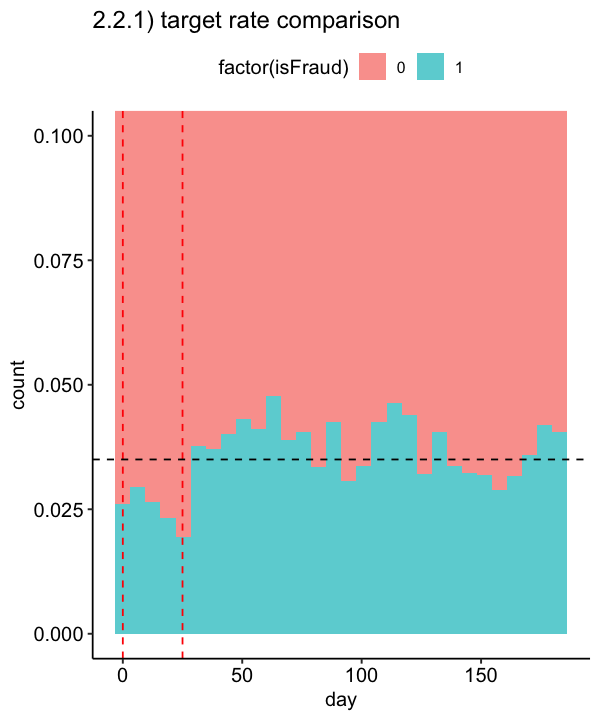

In [10]:
tr$day  <- tr$TransactionDT / 60 / 60 / 24
options(repr.plot.width = 5, repr.plot.height = 6)
ggplot(tr, aes(day, fill = factor(isFraud))) + geom_histogram(bins = 30, position = 'fill', alpha = 0.7) +
geom_vline(xintercept = 0, colour="red", linetype = "dashed") +
geom_vline(xintercept = 25, colour="red", linetype = "dashed") +
coord_cartesian( ylim = c(0, 0.1)) +
geom_hline(yintercept = 0.035, colour="black", linetype="dashed") +
ggtitle("2.2.1) target rate comparison")

빨간색 점선 내 부분(peak 구간)에서의 fraud rate은 평균(검은색 dot)보다 오히려 낮았다.

(해당 구간이 유의미하게 다른 구간과 차이가 나는지 통계적인 검증 필요)

2.2.1.1) **0~25일 기간만 특수하게/일회성으로 발생 and fraud가 아닌 transaction들이 있지않을까?**

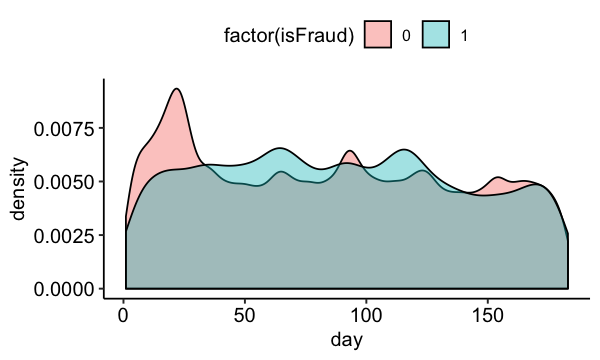

In [13]:
options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(tr, aes(day, fill = factor(isFraud))) + geom_density(alpha = 0.4)

101. peak explain

### 3. transactionAmt

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


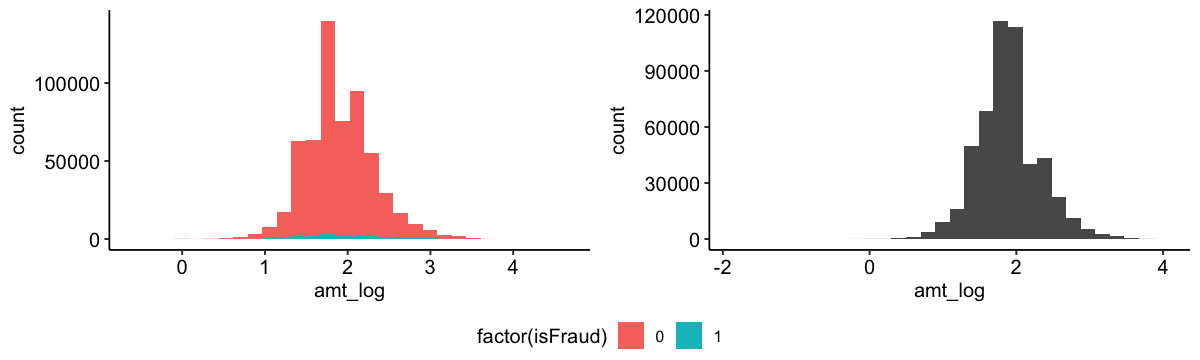

In [95]:
options(repr.plot.width = 5, repr.plot.height = 3)
a1 <- ggplot(tr, aes(TransactionAmt, fill = factor(isFraud))) + geom_histogram()

tr$amt_log  <- log10(tr$TransactionAmt)
te$amt_log  <- log10(te$TransactionAmt)
a1 <- ggplot(tr, aes(amt_log, fill = factor(isFraud))) + geom_histogram()
b1 <- ggplot(te, aes(amt_log)) + geom_histogram()

options(repr.plot.width = 10, repr.plot.height = 3)
figure <- ggarrange(a1, b1,
                    common.legend = TRUE, legend = "bottom",
                    nrow = 1, ncol = 2)
figure

딱히 특별한 패턴은 없는...

### 4. ProductCD

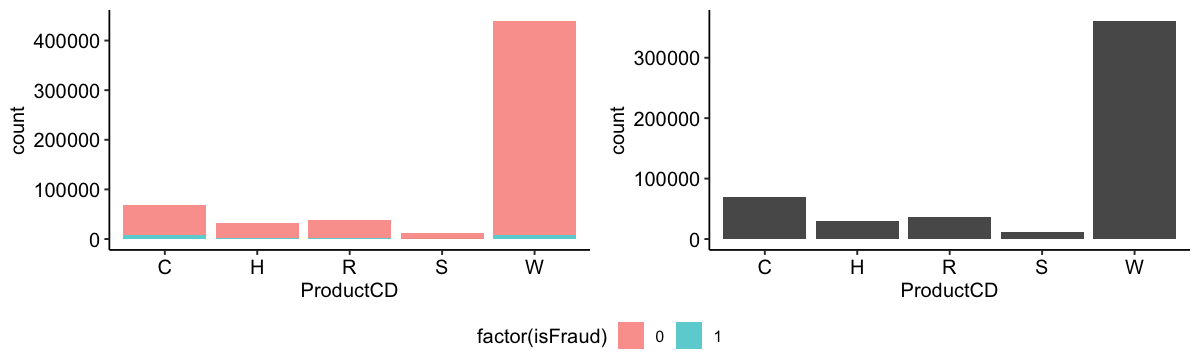

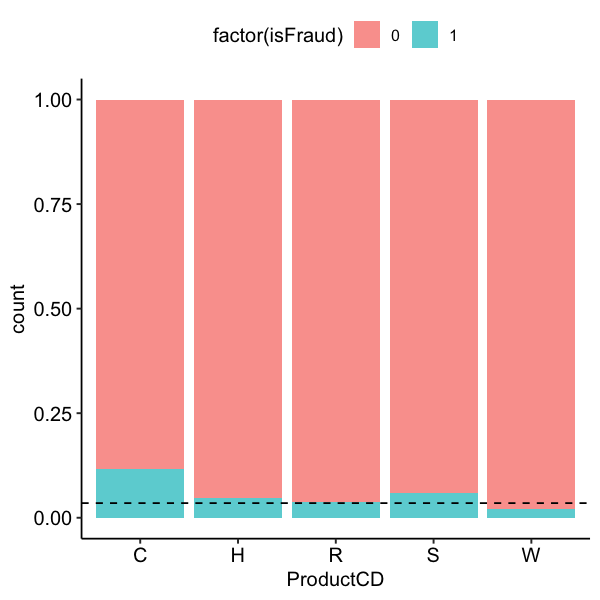

In [96]:
a1 <- ggplot(tr, aes(ProductCD, fill = factor(isFraud))) + geom_bar(alpha = 0.7)
b1 <- ggplot(te, aes(ProductCD)) + geom_bar()

options(repr.plot.width = 10, repr.plot.height = 3)
figure <- ggarrange(a1, b1,
                    common.legend = TRUE, legend = "bottom",
                    nrow = 1, ncol = 2)
figure


options(repr.plot.width = 5, repr.plot.height = 5)
ggplot(tr, aes(ProductCD, fill = factor(isFraud))) + geom_bar(alpha =0.7, position = 'fill') +
geom_hline(yintercept = 0.035, colour="black", linetype="dashed")

"C" 항목이 다른 항목들에 비해 fraud ratio 비율이 월등히 높았다. 4.1) C 항목이 다른 항목과 다른 특이점을 찾자,.

### 5. card1 ~ card6

In [97]:
summary(tr$card1)
summary(tr$card2)
summary(tr$card3)
summary(tr$card4)
summary(tr$card5)
summary(tr$card6)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1000    6019    9678    9899   14184   18396 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  100.0   214.0   361.0   362.6   512.0   600.0    8933 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  100.0   150.0   150.0   153.2   150.0   231.0    1565 

   Length     Class      Mode 
   590540 character character 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  100.0   166.0   226.0   199.3   226.0   237.0    4259 

   Length     Class      Mode 
   590540 character character 

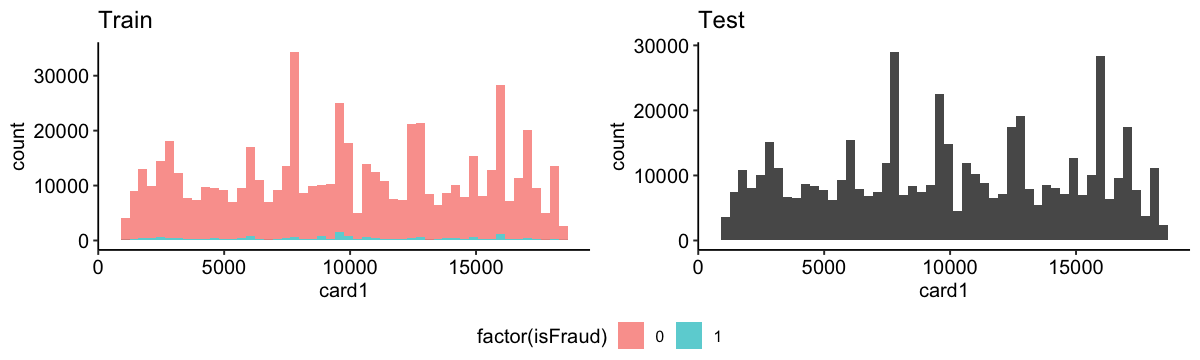

In [98]:
# card1
a1 <- ggplot(tr, aes(card1, fill = factor(isFraud))) + geom_histogram(alpha = 0.7, bins = 50) + ggtitle("Train")
b1 <- ggplot(te, aes(card1)) + geom_histogram(bins = 50) + ggtitle("Test")

options(repr.plot.width = 10, repr.plot.height = 3)
figure <- ggarrange(a1, b1,
                    common.legend = TRUE, legend = "bottom",
                    nrow = 1, ncol = 2)
figure


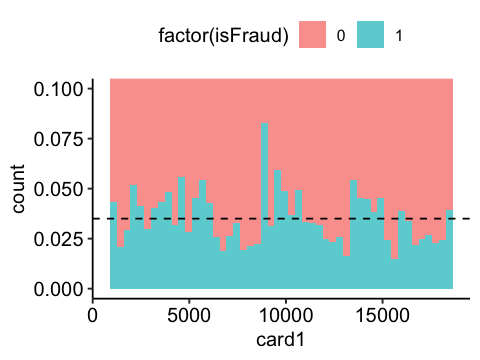

In [99]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(tr, aes(card1, fill = factor(isFraud))) + geom_histogram(alpha = 0.7, position = 'fill', bins = 50) +
geom_hline(yintercept = 0.035, colour="black", linetype="dashed") + coord_cartesian( ylim = c(0, 0.1))

특정 값 근처에 값이 솟구치는 경향을 보이며, fraud ratio도 두개의 큰 dip과 10000 근처에서의 높은 fraud ratio 비율을 보임  
카드 사용액? 카드 한도액?
5.1) card1 컬럼이 의미하는 것은? 그리고 특정 부분에서의 peak과 높은 fraud ratio는 어디에서 기인하는것일까?

Warning message:
“Removed 8933 rows containing non-finite values (stat_bin).”Warning message:
“Removed 8933 rows containing non-finite values (stat_bin).”Warning message:
“Removed 8654 rows containing non-finite values (stat_bin).”

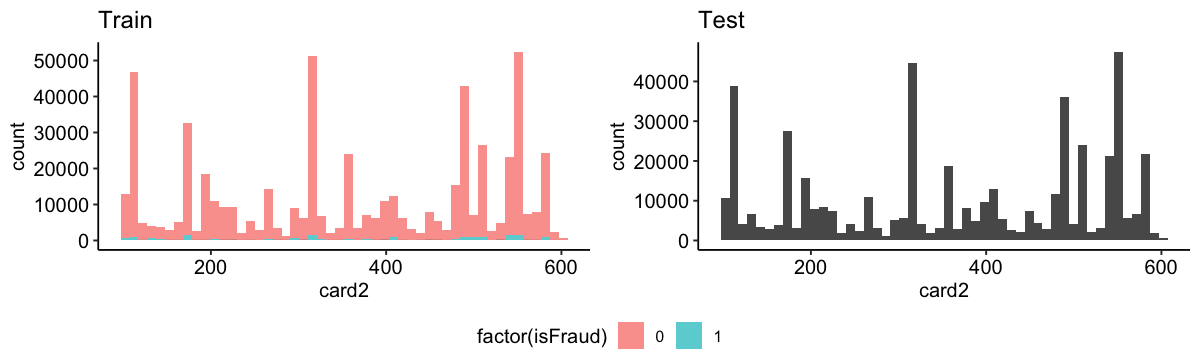

In [100]:
# card2
a1 <- ggplot(tr, aes(card2, fill = factor(isFraud))) + geom_histogram(alpha = 0.7, bins = 50) + ggtitle("Train")
b1 <- ggplot(te, aes(card2)) + geom_histogram(bins = 50) + ggtitle("Test")

options(repr.plot.width = 10, repr.plot.height = 3)
figure <- ggarrange(a1, b1,
                    common.legend = TRUE, legend = "bottom",
                    nrow = 1, ncol = 2)
figure


Warning message:
“Removed 8933 rows containing non-finite values (stat_bin).”

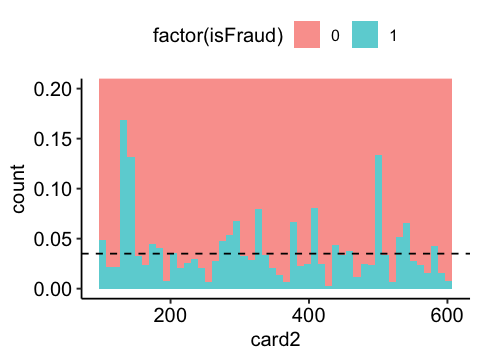

In [101]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(tr, aes(card2, fill = factor(isFraud))) + geom_histogram(alpha = 0.7, position = 'fill', bins = 50) +
geom_hline(yintercept = 0.035, colour="black", linetype="dashed") + coord_cartesian( ylim = c(0, 0.2))

Warning message:
“Removed 1565 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1565 rows containing non-finite values (stat_bin).”Warning message:
“Removed 3002 rows containing non-finite values (stat_bin).”

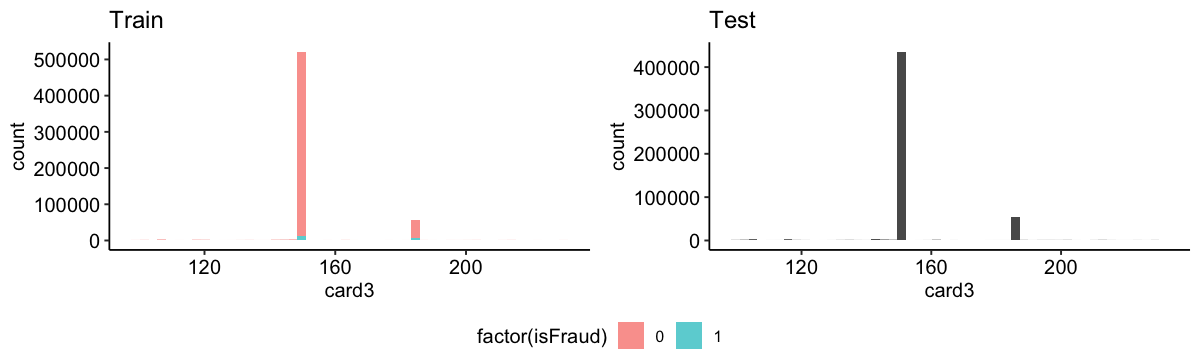

In [102]:
# card3
a1 <- ggplot(tr, aes(card3, fill = factor(isFraud))) + geom_histogram(alpha = 0.7, bins = 50) + ggtitle("Train")
b1 <- ggplot(te, aes(card3)) + geom_histogram(bins = 50) + ggtitle("Test")

options(repr.plot.width = 10, repr.plot.height = 3)
figure <- ggarrange(a1, b1,
                    common.legend = TRUE, legend = "bottom",
                    nrow = 1, ncol = 2)
figure

Warning message:
“Removed 4259 rows containing non-finite values (stat_bin).”Warning message:
“Removed 4259 rows containing non-finite values (stat_bin).”Warning message:
“Removed 4547 rows containing non-finite values (stat_bin).”

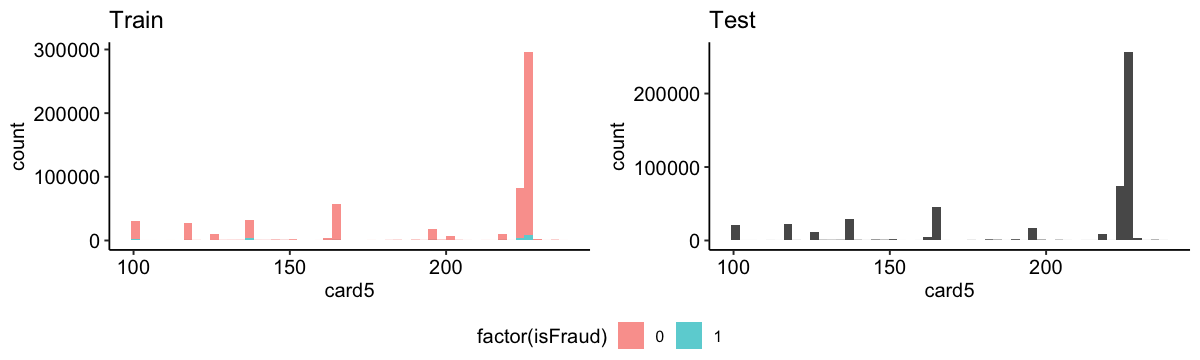

In [103]:
# card5
a1 <- ggplot(tr, aes(card5, fill = factor(isFraud))) + geom_histogram(alpha = 0.7, bins = 50) + ggtitle("Train")
b1 <- ggplot(te, aes(card5)) + geom_histogram(bins = 50) + ggtitle("Test")

options(repr.plot.width = 10, repr.plot.height = 3)
figure <- ggarrange(a1, b1,
                    common.legend = TRUE, legend = "bottom",
                    nrow = 1, ncol = 2)
figure

In [104]:
n_distinct(tr$card3)
n_distinct(tr$card5)

[1] 115

[1] 120

card3와 card5는 categorical 데이터로 봐도 될거같은데..

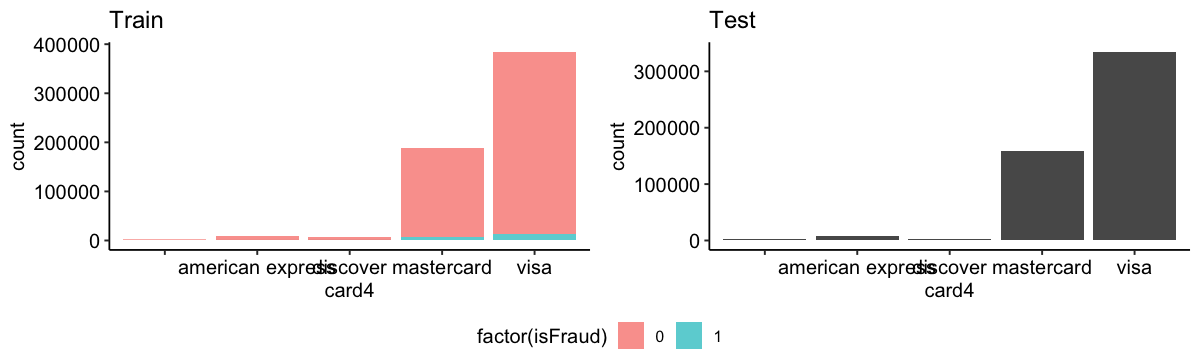

In [105]:
# card4
a1 <- ggplot(tr, aes(card4, fill = factor(isFraud))) + geom_bar(alpha = 0.7) + ggtitle("Train")
b1 <- ggplot(te, aes(card4)) + geom_bar() + ggtitle("Test")

options(repr.plot.width = 10, repr.plot.height = 3)
figure <- ggarrange(a1, b1,
                    common.legend = TRUE, legend = "bottom",
                    nrow = 1, ncol = 2)
figure

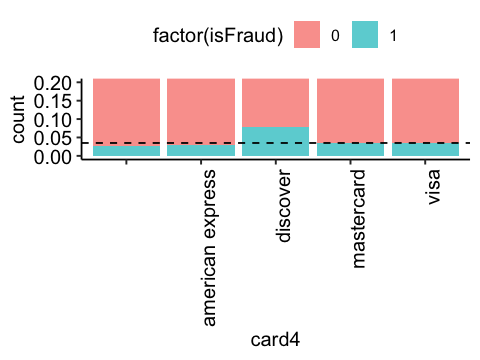

In [106]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(tr, aes(card4, fill = factor(isFraud))) + geom_bar(alpha = 0.7, position = 'fill') +
geom_hline(yintercept = 0.035, colour="black", linetype="dashed") + coord_cartesian( ylim = c(0, 0.2)) +
theme(axis.text.x = element_text(angle = 90, hjust = 1))

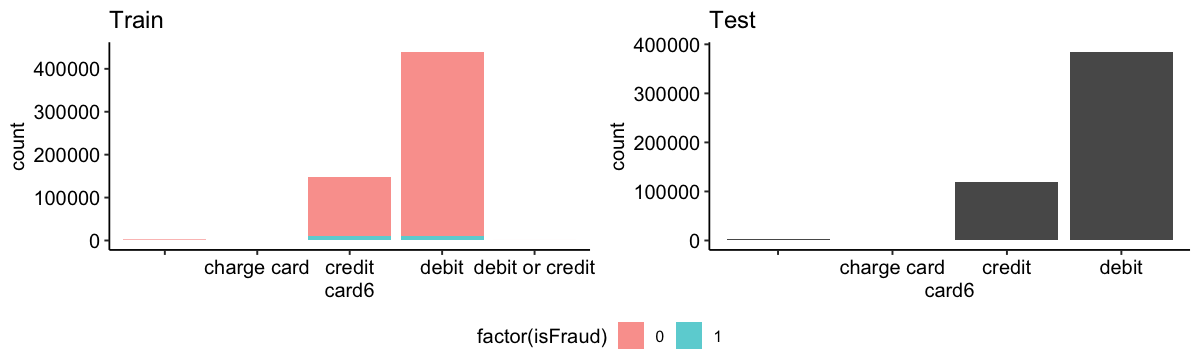

In [107]:
# card6
a1 <- ggplot(tr, aes(card6, fill = factor(isFraud))) + geom_bar(alpha = 0.7) + ggtitle("Train")
b1 <- ggplot(te, aes(card6)) + geom_bar() + ggtitle("Test")

options(repr.plot.width = 10, repr.plot.height = 3)
figure <- ggarrange(a1, b1,
                    common.legend = TRUE, legend = "bottom",
                    nrow = 1, ncol = 2)
figure

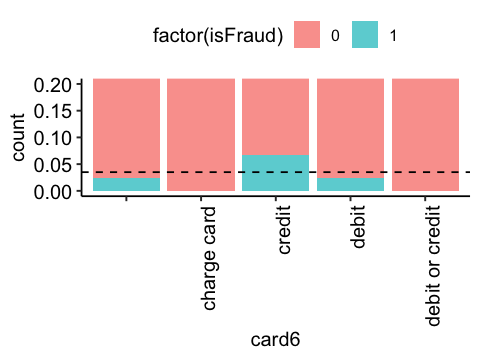

In [108]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(tr, aes(card6, fill = factor(isFraud))) + geom_bar(alpha = 0.7, position = 'fill') +
geom_hline(yintercept = 0.035, colour="black", linetype="dashed") + coord_cartesian( ylim = c(0, 0.2)) +
theme(axis.text.x = element_text(angle = 90, hjust = 1))

card는 discover(비록 소수지만), 형태로는 credit card가 fraud ratio가 더 높았음
5.2) credit, discover의 해당 card들이 card1, card2에 특별한 분포를형성하지는 않을까?

### 6. addr, dist

In [109]:
n_distinct(tr$addr1)
n_distinct(tr$addr2)
n_distinct(tr$dist1)
n_distinct(tr$dist2)

[1] 333

[1] 75

[1] 2652

[1] 1752

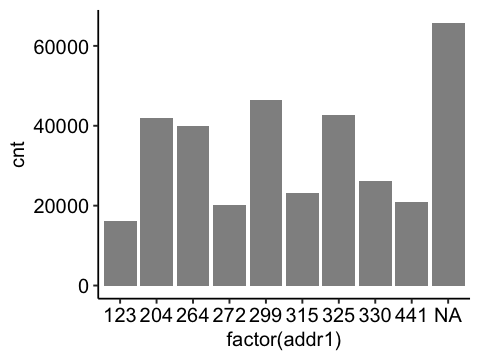

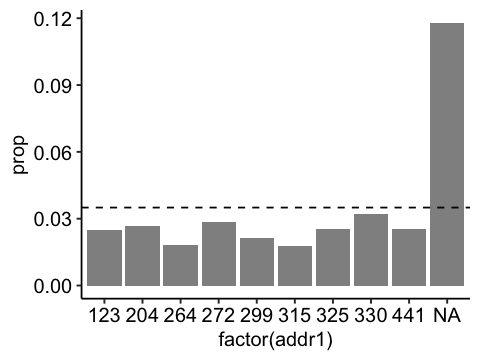

In [83]:
top10_addr1 <- tr[, .(cnt = .N,
                     prop = mean(isFraud)) , by= "addr1"]
top10_addr1 = top10_addr1[order(-cnt)][1:10]
ggplot(top10_addr1, aes(factor(addr1), cnt)) + geom_col(alpha = 0.7) 
ggplot(top10_addr1, aes(factor(addr1), prop)) + geom_col(alpha = 0.7) +
geom_hline(yintercept = 0.035, colour="black", linetype="dashed")

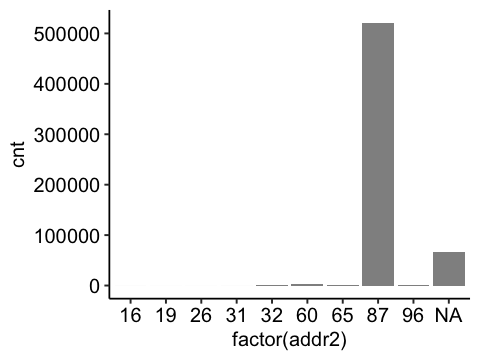

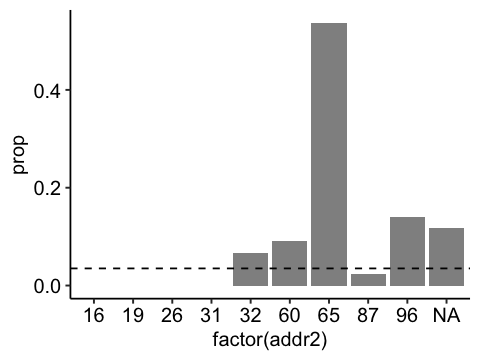

In [110]:
top10_addr2 <- tr[, .(cnt = .N,
                     prop = mean(isFraud)) , by= "addr2"]
top10_addr2 = top10_addr2[order(-cnt)][1:10]
ggplot(top10_addr2, aes(factor(addr2), cnt)) + geom_col(alpha = 0.7) 
ggplot(top10_addr2, aes(factor(addr2), prop)) + geom_col(alpha = 0.7) +
geom_hline(yintercept = 0.035, colour="black", linetype="dashed")

address 에서는 NA값인 경우 fraud가 높았던 점.
6.1 ) add1, add2가 한쪽이 포함하지 않는것으로 보아 직장/자택 주소일 가능성?


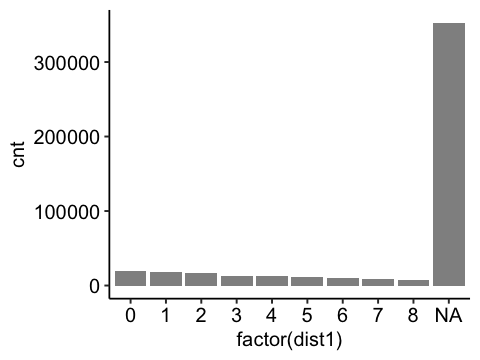

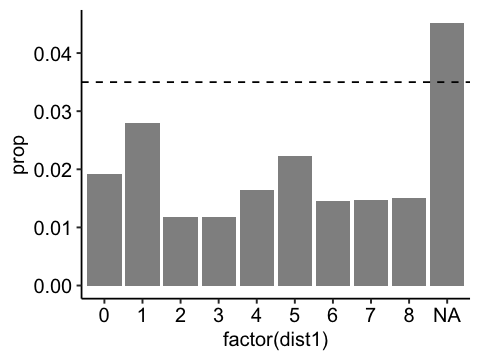

In [111]:
top10_dist1 <- tr[, .(cnt = .N,
                     prop = mean(isFraud)) , by= "dist1"]
top10_dist1 = top10_dist1[order(-cnt)][1:10]
ggplot(top10_dist1, aes(factor(dist1), cnt)) + geom_col(alpha = 0.7) 
ggplot(top10_dist1, aes(factor(dist1), prop)) + geom_col(alpha = 0.7) +
geom_hline(yintercept = 0.035, colour="black", linetype="dashed")

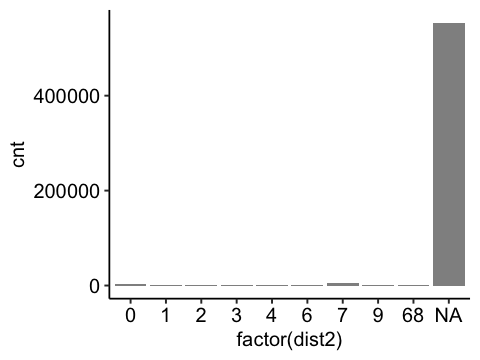

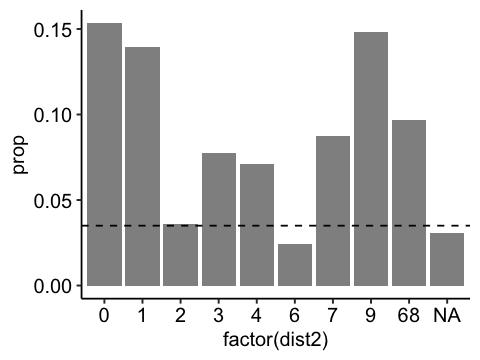

In [113]:
top10_dist2 <- tr[, .(cnt = .N,
                     prop = mean(isFraud)) , by= "dist2"]
top10_dist2 = top10_dist2[order(-cnt)][1:10]
ggplot(top10_dist2, aes(factor(dist2), cnt)) + geom_col(alpha = 0.7) 
ggplot(top10_dist2, aes(factor(dist2), prop)) + geom_col(alpha = 0.7) +
geom_hline(yintercept = 0.035, colour="black", linetype="dashed")

7. emaildomain

8. C1 ~ C13

In [133]:
summary(tr$C1)
summary(tr$C2)
summary(tr$C3)
summary(tr$C4)
summary(tr$C5)
summary(tr$C6)
summary(tr$C7)
summary(tr$C8)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    1.00   14.09    3.00 4685.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    1.00   15.27    3.00 5691.00 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000000  0.000000  0.000000  0.005644  0.000000 26.000000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    0.000    0.000    4.092    0.000 2253.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   5.572   1.000 349.000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    1.000    1.000    9.071    2.000 2253.000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    0.000    0.000    2.849    0.000 2255.000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    0.000    0.000    5.145    0.000 3331.000 

9. V1~V339

### 결론
- train/test 데이터가 time based로 split 되어있으므로 feature 생성시 주의할것
- yearly 패턴이 발생하는것으로 추정되며 어떤 상품/요인들이 패턴을 발생시키는지 확인할 필요
- 상당수의 변수들이 높은 상관관계를 가지는 경향이 있으므로 변수 처리에 유의할것

### 향후 계획
- 각 변수별(card, V, D, C, timestamp) 데이터 컬럼 명 / 변수 분포 파악 

In [3]:
ex <- tr[, .N, by= card1]
summary(ex$N)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    1.00     1.00     4.00    43.57    14.00 14932.00 

In [3]:
te$day  <- round(te$TransactionDT / 60 / 60 / 24, 0)


In [4]:
summary(te$day)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  213.0   264.0   315.0   311.8   363.0   396.0 

In [8]:
nrow(te[day>=365]) / nrow(te)

[1] 0.2411845

[1] 0.8306011